<a href="https://colab.research.google.com/github/suhitaghosh10/colab_examples/blob/master/cifar_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import datasets
from imgaug import augmenters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, UpSampling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.nn import softplus
from sklearn.model_selection import train_test_split
import tensorflow as tf
plt.gray()

<Figure size 432x288 with 0 Axes>

In [0]:
NR_CHANNELS = 1
(train_x, train_y), (val_x, val_y) = datasets.fashion_mnist.load_data()
K.clear_session()
#(train_x, train_y), (val_x, val_y) = datasets.cifar10.load_data()

In [0]:

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, train_x.shape[1], train_x.shape[2], NR_CHANNELS)
val_x = val_x.reshape(-1, val_x.shape[1], val_x.shape[2], NR_CHANNELS)
prod = train_x.shape[1] * train_x.shape[2] 
print(prod)

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)


784
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


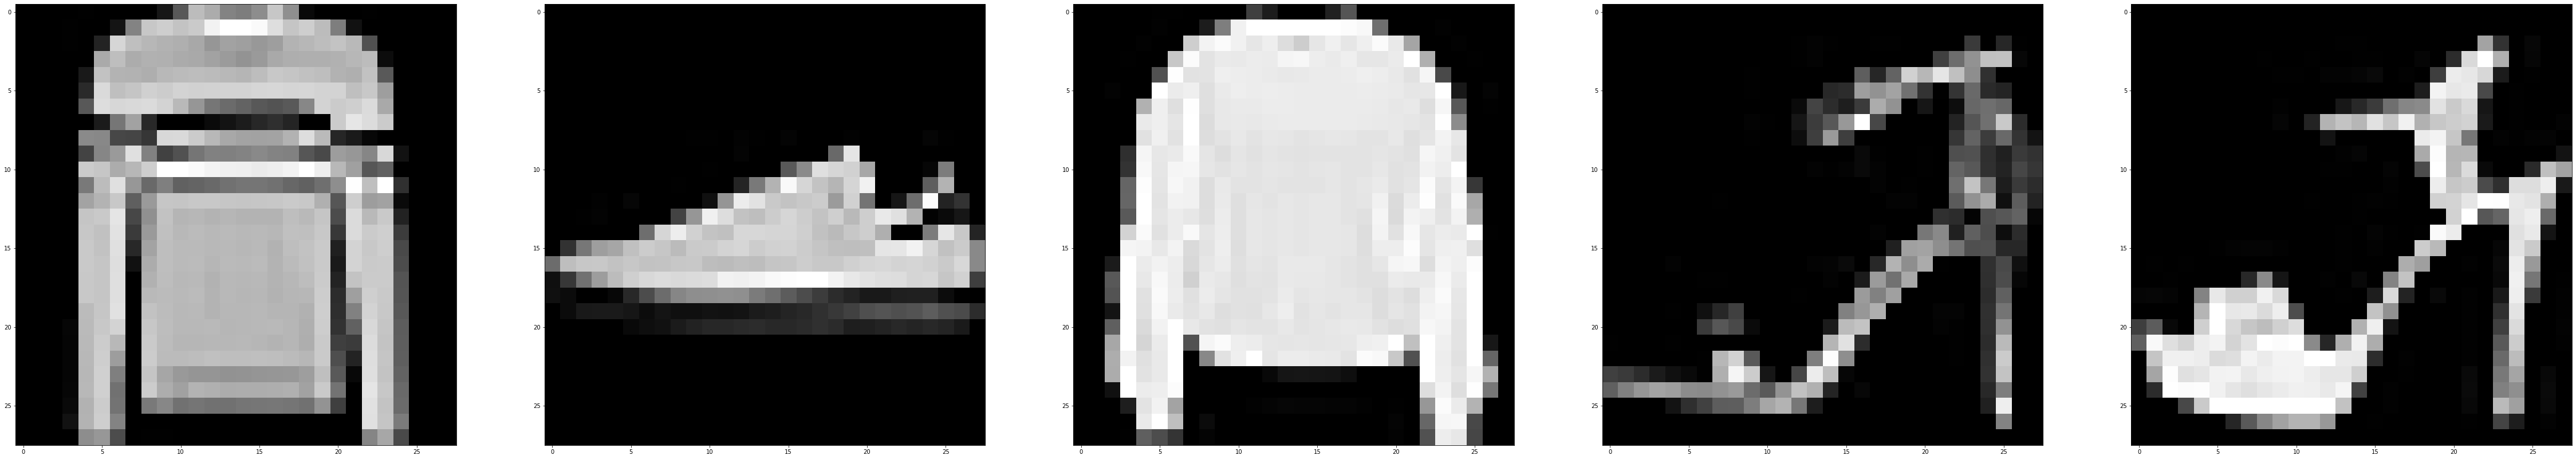

In [0]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i,:,:,0])

In [0]:
K.clear_session()
import tensorflow.nn as nn

batch_size = 16
latent_dim = 2  # Number of latent dimension parameters
activation = 'relu'

input_img = Input(shape=(28,28,1), name="input")

x = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=activation)(input_img)
x = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=activation)(x)
x = Conv2D(filters=64, kernel_size=4, strides=1, padding='same', activation=activation) (x)
x = Flatten()(x)
z_mu = Dense(units=latent_dim, name='mean')(x)
z_log_sigma = Dense(units=latent_dim, name='std_dev')(x)


In [0]:

# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

#x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
#x = Dense(prod, activation='sigmoid', name="original_decoder")(x)

x = Dense(784, activation=activation)(decoder_input)
x = Dense(784, activation=activation) (x)
recovered_size = int(np.sqrt(784))
x = tf.reshape(x, [-1, recovered_size, recovered_size, 1])
x = Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
x = Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
x = Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation=activation)(x)
x = Flatten()(x)
x = Dense(units=28 * 28, activation=None)(x)
x = Dense(units=28 * 28, activation='sigmoid')(x)

decoder = Model(decoder_input, x)
# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)
#img = tf.reshape(x, shape=[-1, 28, 28, 1])

In [0]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_decoder (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 784)               2352      
_________________________________________________________________
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
tf_op_layer_Reshape (TensorF multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 64)        1088      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        65600     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        65600 

In [0]:

class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [0]:
z_decoded

<tf.Tensor 'model/Identity:0' shape=(None, 784) dtype=float32>

In [0]:
# VAE model statement
vae = Model(input_img, y)
optim = RMSprop()
vae.compile(optimizer=optim, loss=None)

In [0]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   1088        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     65600       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     65600       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
#train_x = np.reshape(train_x, (train_x.shape[0], prod))
#val_x = np.reshape(val_x, (val_x.shape[0], prod))

In [0]:

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=5, mode='auto')

vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None),
        callbacks=[early_stopping])

Epoch 1/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3516 - val_loss: 0.3317
Epoch 2/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3281 - val_loss: 0.3276
Epoch 3/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3253 - val_loss: 0.3369
Epoch 4/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3241 - val_loss: 0.3254
Epoch 5/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3232 - val_loss: 0.3240
Epoch 6/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3227 - val_loss: 0.3260
Epoch 7/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3222 - val_loss: 0.3259
Epoch 8/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3220 - val_loss: 0.3263
Epoch 9/20
3750/3750 [==============================] - 58s 15ms/step - loss: 0.3214 - val_loss: 0.3236
Epoch 10/20
3750/3750 [==============================] - 58s 15m

In [0]:
from scipy.stats import norm

# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
print(grid_x)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print(grid_y)
batch_size = 2


[-1.64485363 -1.29669299 -1.05927692 -0.87016448 -0.7079966  -0.56263389
 -0.42831603 -0.30133652 -0.17905472 -0.05940243  0.05940243  0.17905472
  0.30133652  0.42831603  0.56263389  0.7079966   0.87016448  1.05927692
  1.29669299  1.64485363]
[-1.64485363 -1.29669299 -1.05927692 -0.87016448 -0.7079966  -0.56263389
 -0.42831603 -0.30133652 -0.17905472 -0.05940243  0.05940243  0.17905472
  0.30133652  0.42831603  0.56263389  0.7079966   0.87016448  1.05927692
  1.29669299  1.64485363]


[[-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]
 [-1.64485363 -1.64485363]]
(16, 2)
(16, 784)
(28, 28)


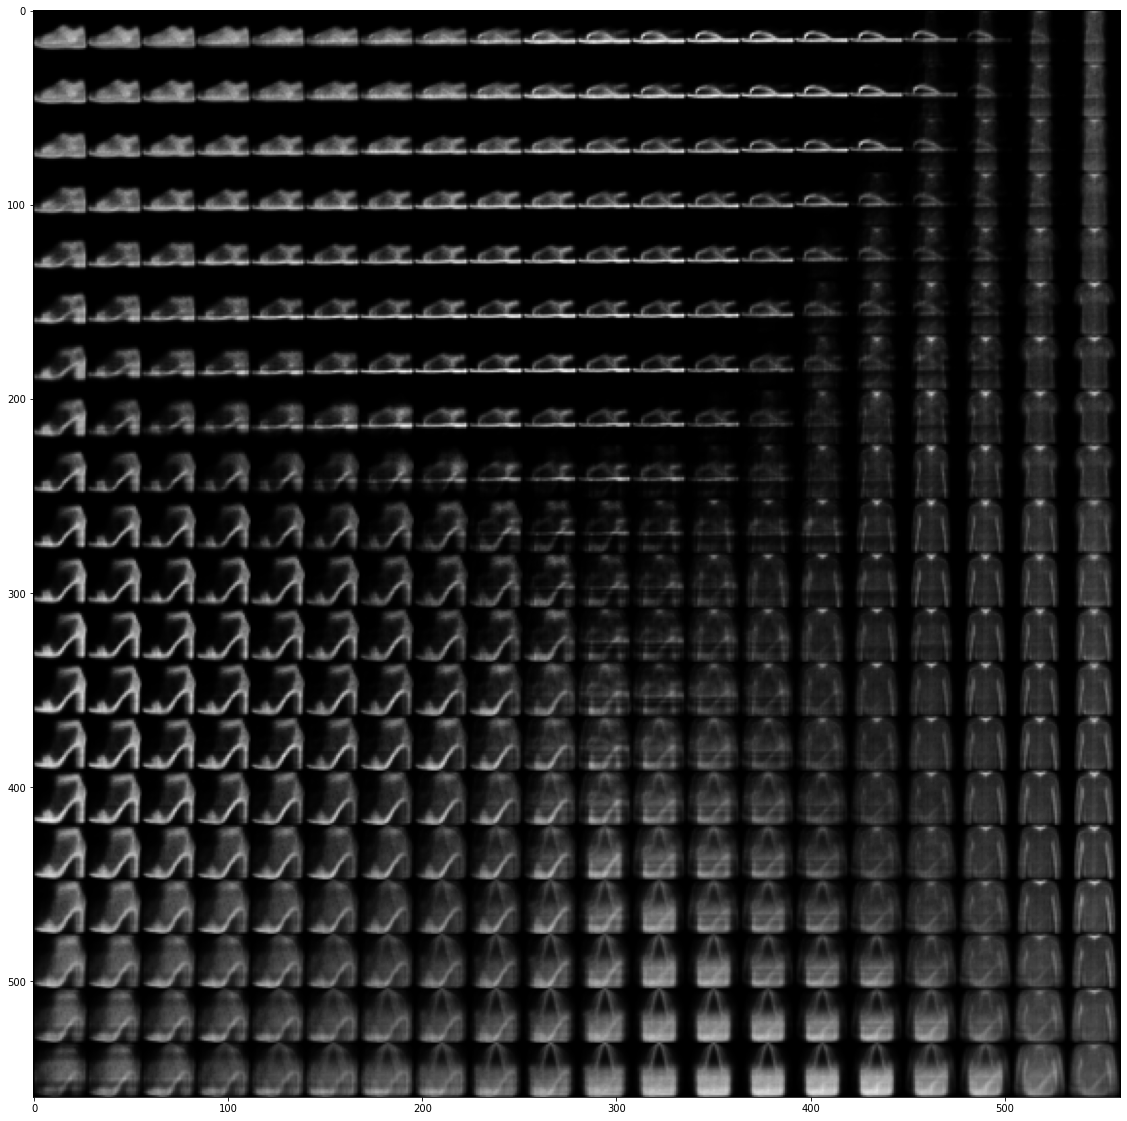

In [0]:
batch_size = 16
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        if i==0 and j==0:
          print(z_sample)
          print(z_sample.shape)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        if i==0 and j==0:
          print(x_decoded.shape)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        if i==0 and j==0:
          print(digit.shape)

        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

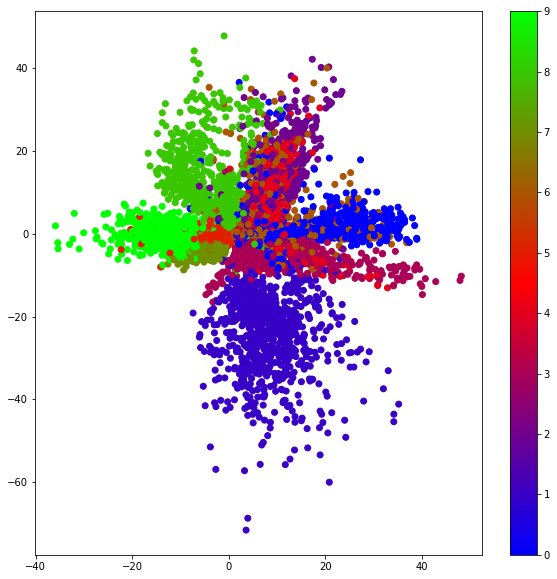

In [0]:

encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(val_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=val_y, cmap='brg')
plt.colorbar()
plt.show()
# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot

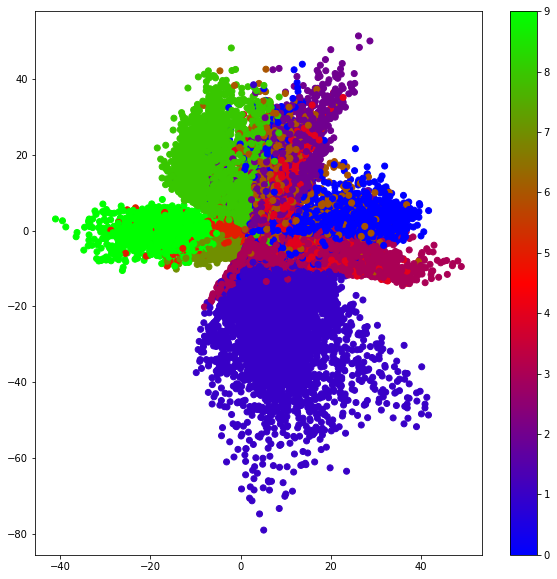

In [0]:

encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()
# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot